# LSTM Covid-19 Data Analysis

This notebook walks through implementing lstm neural networks as well as data loading on JHU's covid-19 time-series data, maintained here: https://github.com/CSSEGISandData/COVID-19. In the this walk-through, we use our predictor and data loader classes that are in the ML module in this repository.

In [1]:
# basic python libs
import os, wget, json

# deep learning framework tools
import torch
from torch import nn, optim

# data analysis libs
import numpy as np, pandas as pd

# visualization libs
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

# ML pre-processing
from sklearn.preprocessing import MinMaxScaler

In [2]:
# our predictor and data loader
from ML.lstm_torch import LSTM_data_loader, LSTM_Predictor, train_lstm, predict_future

import warnings
warnings.filterwarnings('ignore')

Set all of our visualization preferences.

In [3]:
%matplotlib inline

In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.6)
sns.set_palette(sns.color_palette("husl", 8))

rcParams['figure.figsize'] = 16, 12
register_matplotlib_converters()

In [5]:
# set our random seed
RANDOM_SEED = 26
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

For doing a country-level analysis, we'll want to download the most recent data from the JHU database. That said, up until 3/22, the researchers were reporting state level data. There was functionality built into the the data-loading class to subset down to the state-level for project covid -19 growth for each state.

In [6]:
if os.path.isfile('time_series_covid19_confirmed_global.csv'):
    os.remove('time_series_covid19_confirmed_global.csv')
    
wget.download('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

'time_series_covid19_confirmed_global.csv'

## World covid-19 Growth Analysis

Lets start out with not sub-setting our data for modeling -- let's aggregate all of our information over the entire world, largely because as we have more data points and will have a better fitting model. Since we're using long short-term memory machine networks in order to model out confirmed-case growth, if we have a bunch of 0s at the beginning of out time-series data and it begins to ramp up quickly, our model is going to have a hard time fitting to the sudden jump. If we capture as much of that as possible (i.e. use as much of the data as possible) we should see better results.

In [7]:
tdf = pd.read_csv('time_series_covid19_confirmed_global.csv')

In [8]:
tdf.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,24,40,40,74,84,94,110,110,120
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,70,76,89,104,123,146,174,186,197,212
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,90,139,201,230,264,302,367,409,454,511
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,75,88,113,133,164,188,224,267,308,334
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,1,2,2,3,3,3,4,4,5,7


The first thing we're going to use is the `LSTM_data_loader` class. Since we're sub-setting in a couple different way, for usability we wrapped some of the basic manipulations into a data loader class. Most importantly, we're passing in a dataframe of the format above (how JHU has been providing their data). If we pass this in and no other arguments, we will simply prep our data to model at the world-level. After that, we can pass in a country name that exists in the `Country/Region` column that we would like to subset by. If we use one of the archived data sets that contains state-level information, we can pass in a state abbreviation as well. In order to do this, we also need to pass in a dictionary where the abbreviation maps to the name of the state (i.e {'WA' : 'Washington'}. This dictionary just helps capture all instances in the dataframe where the state is mentioned).

In [9]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     state_mapper=None)

We still need to call the `subset_df` method off of our LSTM data loader as it still removes some columns off of our data that we're not going to want for the next step.

In [10]:
world_data_loader.subset_df()
world_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,0,0,0,0,0,0,0,0,0,0,...,24,24,40,40,74,84,94,110,110,120
1,0,0,0,0,0,0,0,0,0,0,...,70,76,89,104,123,146,174,186,197,212
2,0,0,0,0,0,0,0,0,0,0,...,90,139,201,230,264,302,367,409,454,511
3,0,0,0,0,0,0,0,0,0,0,...,75,88,113,133,164,188,224,267,308,334
4,0,0,0,0,0,0,0,0,0,0,...,1,2,2,3,3,3,4,4,5,7


For plotting out our data, making predictions, and generally working with our data, it's more convenient to have our data in a datetime format, so we transfer switch our axes and cast out time-step information to a date-time type. The `delta` argument determines if our new cases are either the cumulative amount of cases in a country, or the amount of new daily cases. This changes the context of what we're predicting and modeling as well. For this, we're sticking with cumulative cases as typically these networks have an easier time fitting to smoother curves. That said, daily differences more explicitly capture factors such as momentum and negative swings.

In [11]:
world_data_loader.transform_df_datetime(delta=False)
world_data_loader.df.head()

Data in cumulative


2020-01-22     555
2020-01-23     654
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [12]:
len(world_data_loader.df)

68

Since we just packaged up a pandas dataframe inside of our loading class, we can still call easy pandas lotting features off of it. Inspecting the plot, we can see that there is significant momentum heading into February (the spike in cases in China) and a drop (a subsuquent dropping off ocf new reported cases there). At that point though, we can see the virus spread picking up again as it had reached other nations.

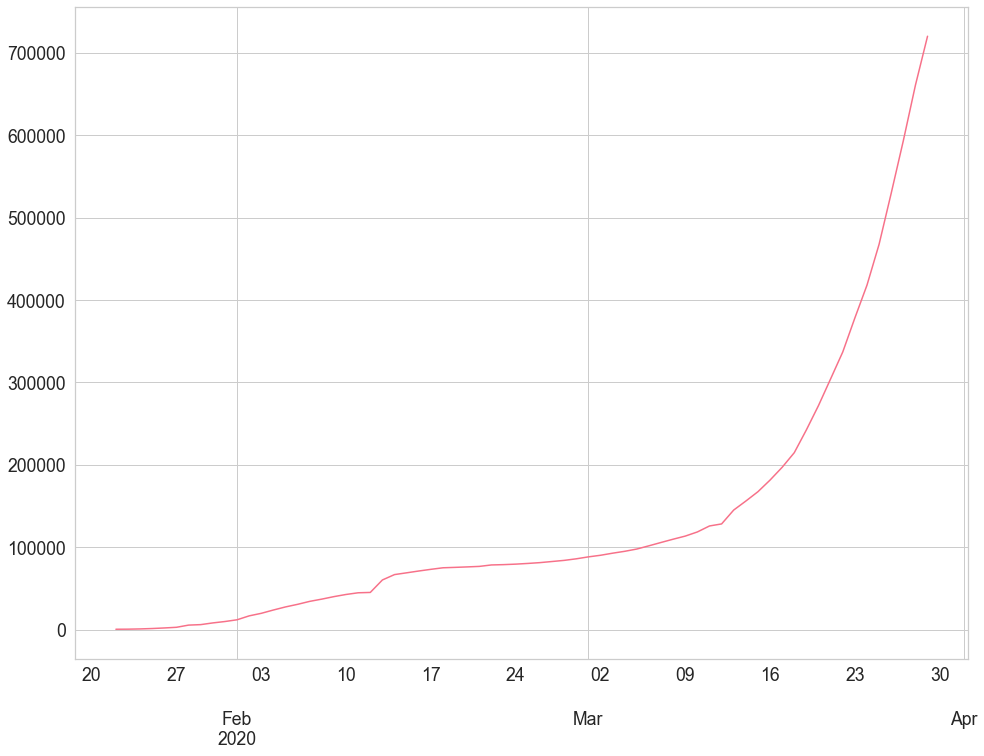

In [13]:
world_data_loader.df.plot(label="Confirmed Cases")

We can then call a method in the class to create our training and testing data sets. Pass in however much you want for the training data, but now we only have 56 days, for this example I'm just going to pass in the last 5. The default value in the method is 0, which will not create a test data.

In [14]:
world_data_loader.gen_data_sets(test_data_size=7)

We then extract these data sets data sets and do some conversions into torch tensors.

In [15]:
X_train, y_train = world_data_loader.set_seq(train=True, sequence_lenth=3)
X_test, y_test = world_data_loader.set_seq(train=False, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

Instantiate our model with a architecture (a couple layers, 512 neurons a piece). A more complex model is configurable by instantiating the class to a certain degree. More bespoke network architectures can be easily implemented by altering the `LSTM_Predictor` class.

In [16]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

We then use the training function that we imported, where we pass in our data sets and how long we want it to train for -- we then get our MSE history and our trained model.

In [17]:
model, trainhistory, testhistory = train_lstm(model,
                                          X_train,
                                          y_train,
                                          X_test,
                                          y_test,
                                          epochs=500)

Epoch 0 train loss: 4.473423004150391 test loss: 8.875703811645508
Epoch 50 train loss: 2.077369213104248 test loss: 6.024965286254883
Epoch 100 train loss: 1.022171974182129 test loss: 3.1857528686523438
Epoch 150 train loss: 1.2514647245407104 test loss: 3.8043248653411865
Epoch 200 train loss: 0.1621456891298294 test loss: 0.4455101191997528
Epoch 250 train loss: 0.1978479027748108 test loss: 1.0921111106872559
Epoch 300 train loss: 0.2297237664461136 test loss: 1.1654846668243408
Epoch 350 train loss: 0.1717296838760376 test loss: 1.0586532354354858
Epoch 400 train loss: 0.16939549148082733 test loss: 0.9693078994750977
Epoch 450 train loss: 0.17513619363307953 test loss: 0.8189882040023804


Just for a sanity check, let's visually inspect our training progress. We can see that starting around epoch 100 with respect to our training data, and at ~ epoch 150 for our testing data, the MSEs (squared errors of the data points) level off.

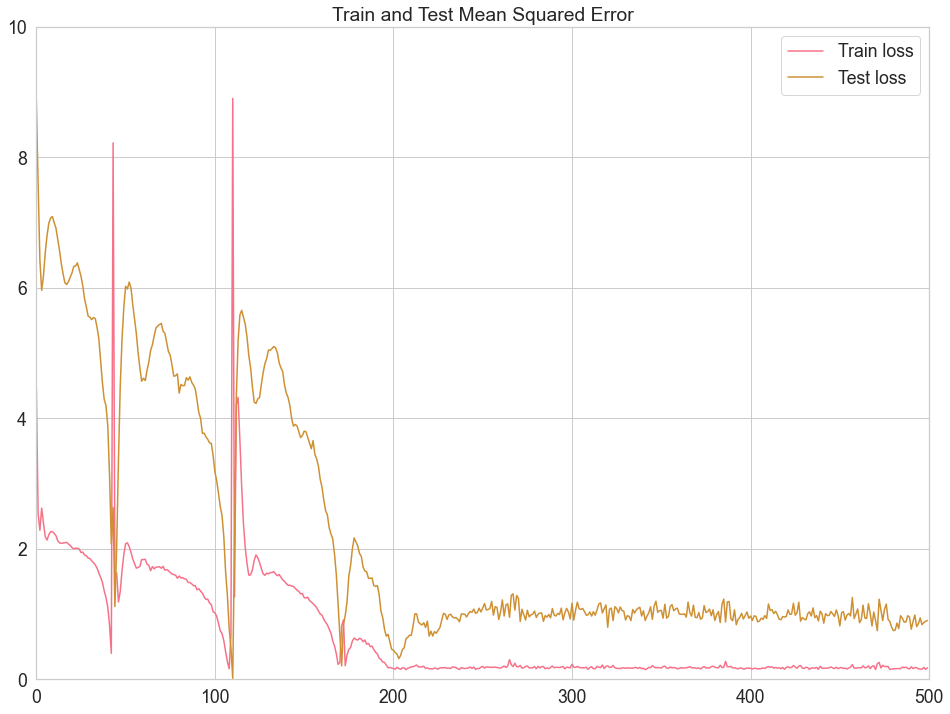

In [18]:
plt.plot(trainhistory, label="Train loss")
plt.plot(testhistory, label="Test loss")
plt.ylim((0, 10))
plt.xlim((0, 500))
plt.title(label='Train and Test Mean Squared Error')
plt.legend()

In order to make predictions, we also have an future-looking inference function `predict_future`, which takes how far out we want to predict our sequence length, and our model.

In [19]:
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = world_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print([int(x) for x in true_cases.tolist()])

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print([int(x) for x in predicted_cases.tolist()])

[529591, 593291, 660706]
[544688, 621318, 699713]


Using some intuition here, even though our test MSE was considerably larger than our training MSE, we can visually ascertain that our model fit to the data very well, and that these higher MSEs are likely due to the rapidly increasing y-values we're observing.

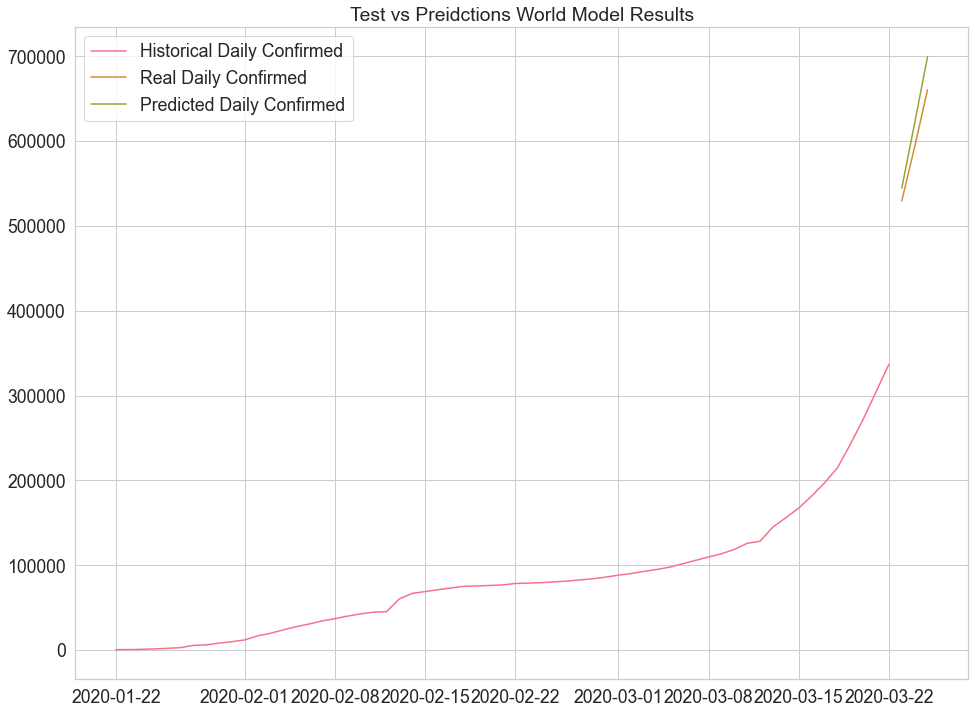

In [20]:
plt.plot(
  world_data_loader.df.index[:len(world_data_loader.train_data)],
  world_data_loader.scaler.inverse_transform(world_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  world_data_loader.df.index[len(world_data_loader.train_data):len(world_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.title(label='Test vs Preidctions World Model Results')
plt.legend()

## World - Future

For our future predictions the only real modifications that we make to our previous analysis is that we keep all of our data as training data for a better fit, and see what the model outputs.

In [21]:
world_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country=None,
                                     state_mapper=None)

world_data_loader.subset_df()

world_data_loader.transform_df_datetime(delta=True)

world_data_loader.gen_data_sets(test_data_size=0)

X_train, y_train = world_data_loader.set_seq(train=True, sequence_lenth=3)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, _, _ = train_lstm(model,
                        X_train,
                        y_train,
                        epochs=500)

Data is converted to daily delta
Epoch 0 train loss: 4.9530134201049805
Epoch 50 train loss: 1.2017474174499512
Epoch 100 train loss: 0.8091838955879211
Epoch 150 train loss: 0.6808208227157593
Epoch 200 train loss: 0.8740628957748413
Epoch 250 train loss: 0.7138044238090515
Epoch 300 train loss: 0.89370197057724
Epoch 350 train loss: 0.7379874587059021
Epoch 400 train loss: 0.6984184384346008
Epoch 450 train loss: 0.7362701296806335


Make predictions for 10 future days.

In [22]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = world_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print([int(x) for x in predicted_cases.tolist()])

[69657, 77763, 85478, 92633, 99108, 104857, 109882, 114222, 117930, 121070]


After all that... our model looks pretty linear, predicting an increase of ~10k cases a day. 

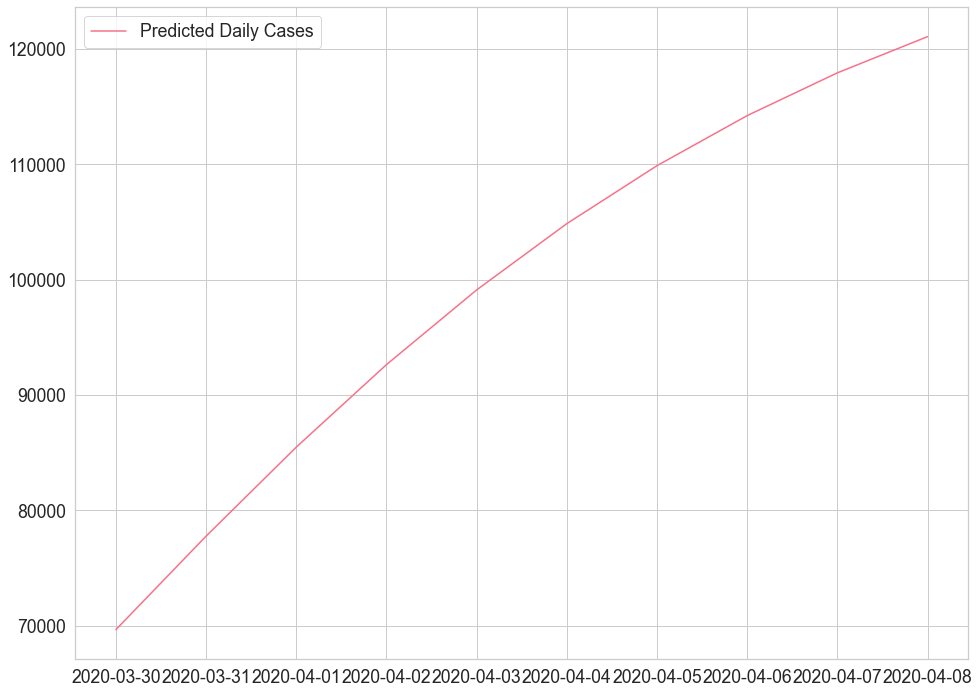

In [23]:
predicted_index = pd.date_range(
  start=world_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(label='Predicted New-Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

And our data and predictions together.

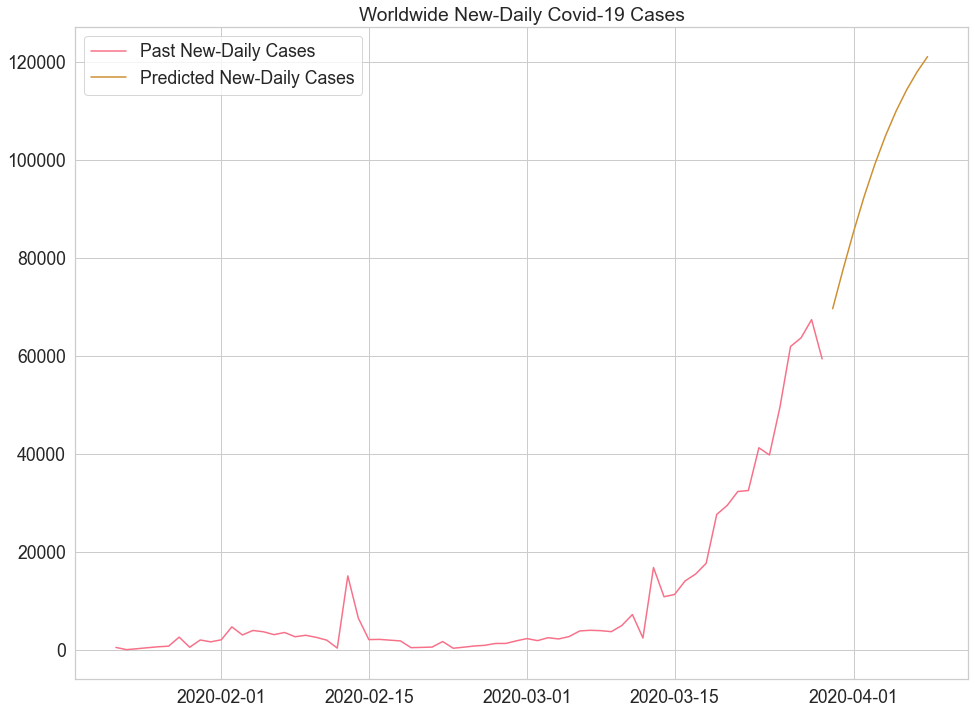

In [24]:
plt.plot(world_data_loader.df, label='Past New-Daily Cases')
plt.plot(predicted_cases, label='Predicted New-Daily Cases')
plt.title('Worldwide New-Daily Covid-19 Cases')
plt.legend()

## Italian Analysis

Okay, lets try something a bit harder that has considerabley less data then aggergating over the whole world. Lets subset our world data down to just Italian cases.

In [25]:
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country='Italy',
                                     state_mapper=None)

In [26]:
italy_data_loader.subset_df()
italy_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,0,0,0,0,0,0,0,0,0,2,...,47021,53578,59138,63927,69176,74386,80589,86498,92472,97689


In [27]:
italy_data_loader.transform_df_datetime(delta=True)
italy_data_loader.df.head()

Data is converted to daily delta


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

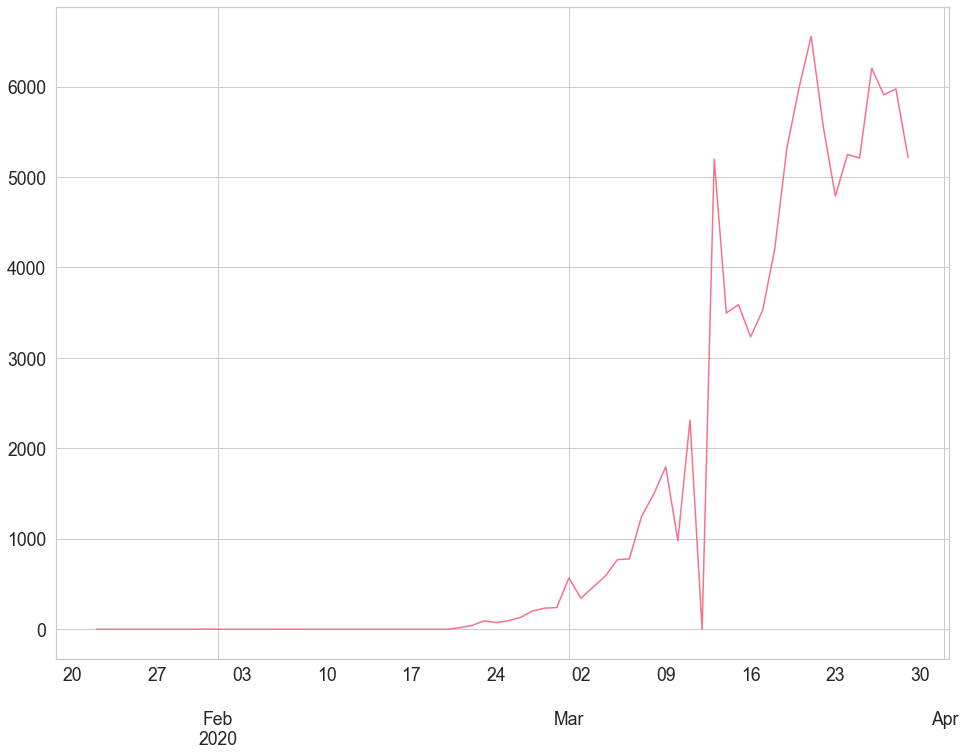

In [28]:
italy_data_loader.df.plot(label="Confirmed Cases")

In [29]:
# give ourselves 7 days of testing data
italy_data_loader.gen_data_sets(test_data_size=7)

# create our data splits
X_train, y_train = italy_data_loader.set_seq(train=True,sequence_lenth=3)
X_test, y_test = italy_data_loader.set_seq(train=False, sequence_lenth=3)

# cast to our orch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# fit our basic model
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

# train our model
model, _, _ = train_lstm(model,
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      epochs=300)

Epoch 0 train loss: 4.864616394042969 test loss: 2.486133575439453
Epoch 50 train loss: 1.0342633724212646 test loss: 0.07373921573162079
Epoch 100 train loss: 1.0850764513015747 test loss: 0.03489727899432182
Epoch 150 train loss: 0.9055806398391724 test loss: 0.05286869406700134
Epoch 200 train loss: 0.8688455820083618 test loss: 0.07384927570819855
Epoch 250 train loss: 0.7882348299026489 test loss: 0.1857774257659912


Now that we have our model trained on Italian data, lets see some predictions just for Italian new-daily cases.

In [30]:

seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = italy_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = italy_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[6203. 5909. 5974.]
[8170.17476046 8988.2301966  9848.21127868]


Looking at our model, seems like it's predicting daily cases to take off; but there seems to be a bit of a downturn in the real data. This is absolutely a shortcoming of using a LSTM with relatively short sequences to model un-smooth data.

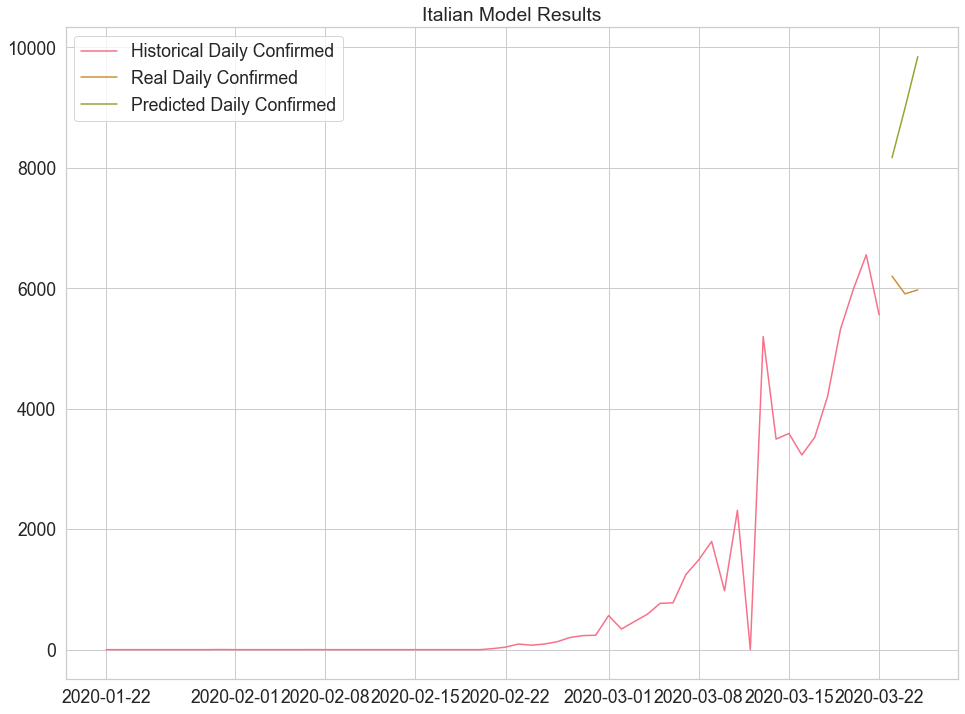

In [31]:
plt.plot(
  italy_data_loader.df.index[:len(italy_data_loader.train_data)],
  italy_data_loader.scaler.inverse_transform(italy_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  italy_data_loader.df.index[len(italy_data_loader.train_data):len(italy_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.title(label='Italian Model Results')
plt.legend()

## Italy - Future

Now lets do our same future analysis, but just with Italy.

In [32]:
# instantiate our data loader
italy_data_loader = LSTM_data_loader(df=tdf,
                                     region_abr=None,
                                     country="Italy",
                                     state_mapper=None)

# subset by Italian data
italy_data_loader.subset_df()

# set to date time and aggregate
italy_data_loader.transform_df_datetime(delta=True)

# set up our data sets with no testing data
italy_data_loader.gen_data_sets(test_data_size=0)

# get our training data sets from our data loader and cast to torch tensors
X_train, y_train = italy_data_loader.set_seq(train=True,sequence_lenth=3)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

# instantiate our model
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

# train our model
model, _, _ = train_lstm(model,
                      X_train,
                      y_train,
                      epochs=500)

Data is converted to daily delta
Epoch 0 train loss: 9.326820373535156
Epoch 50 train loss: 1.1948469877243042
Epoch 100 train loss: 1.0049649477005005
Epoch 150 train loss: 0.8093647956848145
Epoch 200 train loss: 0.7260105609893799
Epoch 250 train loss: 0.584488570690155
Epoch 300 train loss: 0.5752640962600708
Epoch 350 train loss: 0.5261685848236084
Epoch 400 train loss: 0.5416697263717651
Epoch 450 train loss: 0.5139973163604736


Make our predictions for 10 days out with our Italian-trained model.

In [33]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = italy_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[6380.32440406 6546.25341195 6677.82202482 6786.34548497 6877.91640472
 6956.09366071 7023.20814908 7080.9568435  7130.68106449 7173.49545252]


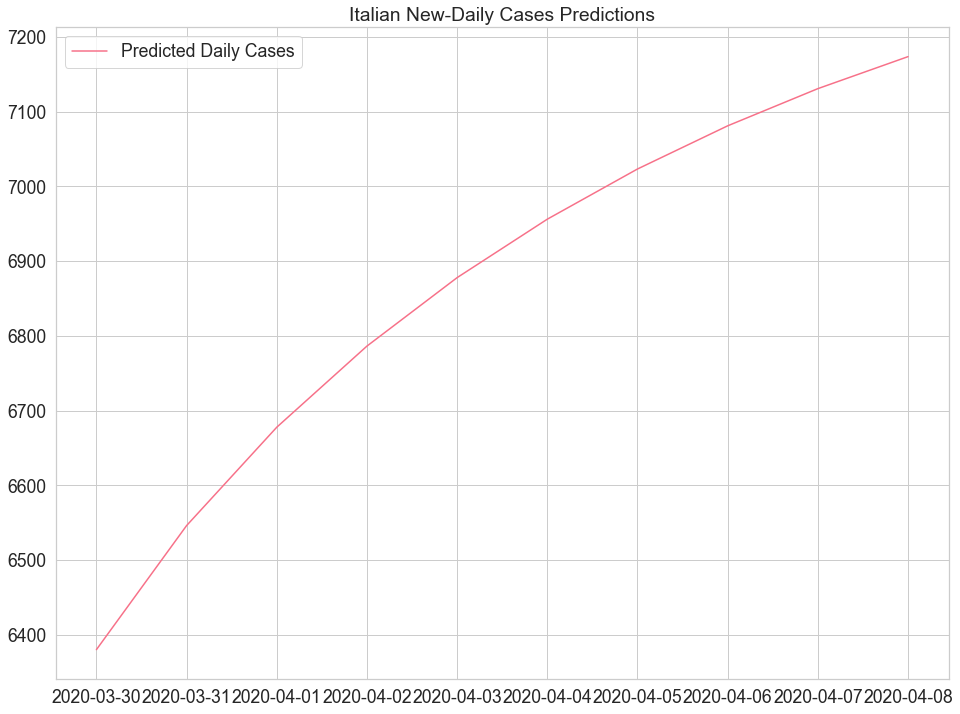

In [34]:
predicted_index = pd.date_range(
  start=italy_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.title(label='Italian New-Daily Cases Predictions')
plt.legend()

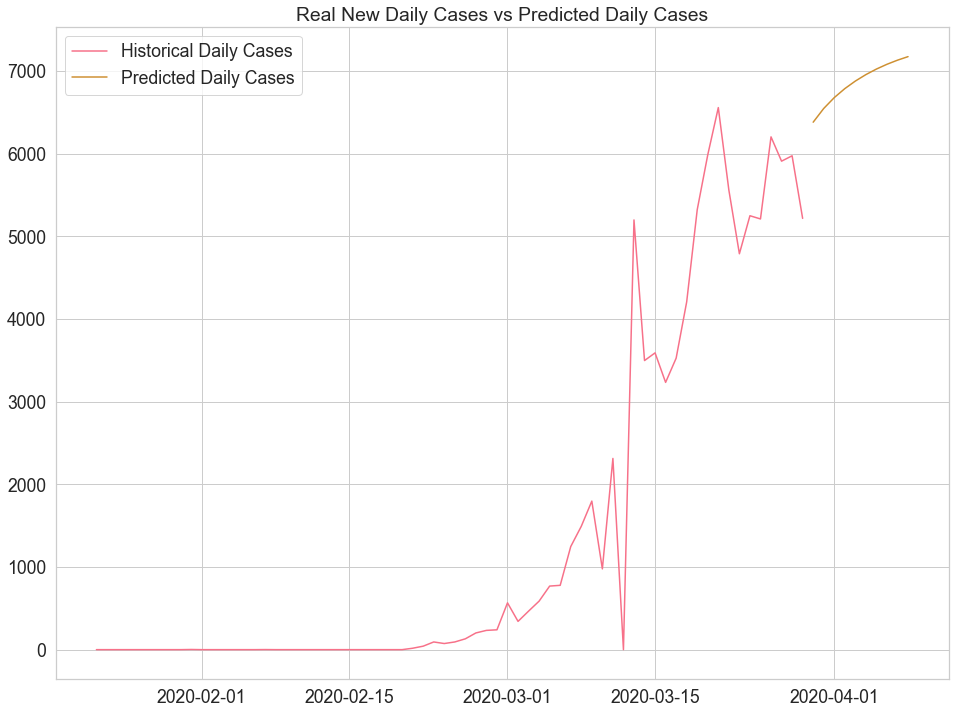

In [35]:
plt.plot(italy_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.title('Real New Daily Cases vs Predicted Daily Cases')
plt.legend()

Lets collect data for prediction for all of the countries in our data set.

## US States Analysis

### Washington State

To do our analyses on US States, we can just feed in an abbreviation, but we have a good amount of disparate naming that takes place in our data set that looks like so.

In [36]:
states_df = pd.read_csv('./data/jhu_data/time_series_19-covid-Confirmed_3_22.csv')
states_df.drop(columns=['Unnamed: 0'],inplace=True)

In [37]:
# some state names
states_df[states_df['Country/Region']=='US'][:5]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,568,572,643,904,1076,1014,1376,1524,1793,1996
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,421,525,732,967,1706,2495,5365,8310,11710,15793
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,282,340,426,557,698,751,952,1177,1364,1642
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,123,138,164,197,218,218,328,413,525,646
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,47,47,47,47,49,49,49


In [38]:
# some mixed types
states_df[states_df['Country/Region']=='US'][-5:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
417,Puerto Rico,US,18.2208,-66.5901,0,0,0,0,0,0,...,0,3,5,5,5,5,5,14,21,23
431,Guam,US,13.4443,144.7937,0,0,0,0,0,0,...,0,0,3,3,3,5,12,14,15,27
448,Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,1,1,1,2,2,3,3,3,3
491,United States Virgin Islands,US,18.3358,-64.8963,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
492,US,US,37.0902,-95.7129,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So lets get some of this from a hand json we were already using for geo-spatial information in our visualization to get some name metadata.

In [39]:
with open('./data/geo_data/us-states.json', 'r') as f:
    us_states = json.load(f)
    
state_abrs = [x['id'] for x in us_states['features']]

state_mapper_lst = [{x['properties']['name']:x['id']} for x in us_states['features']]

state_mapper_lst
state_mapper = {}
for s in state_mapper_lst:
    state_mapper.update(s)

First, lets pick a state that has a considerable outbreak, Washington. Othe than that, our analysis is essentially the same.

Data in cumulative


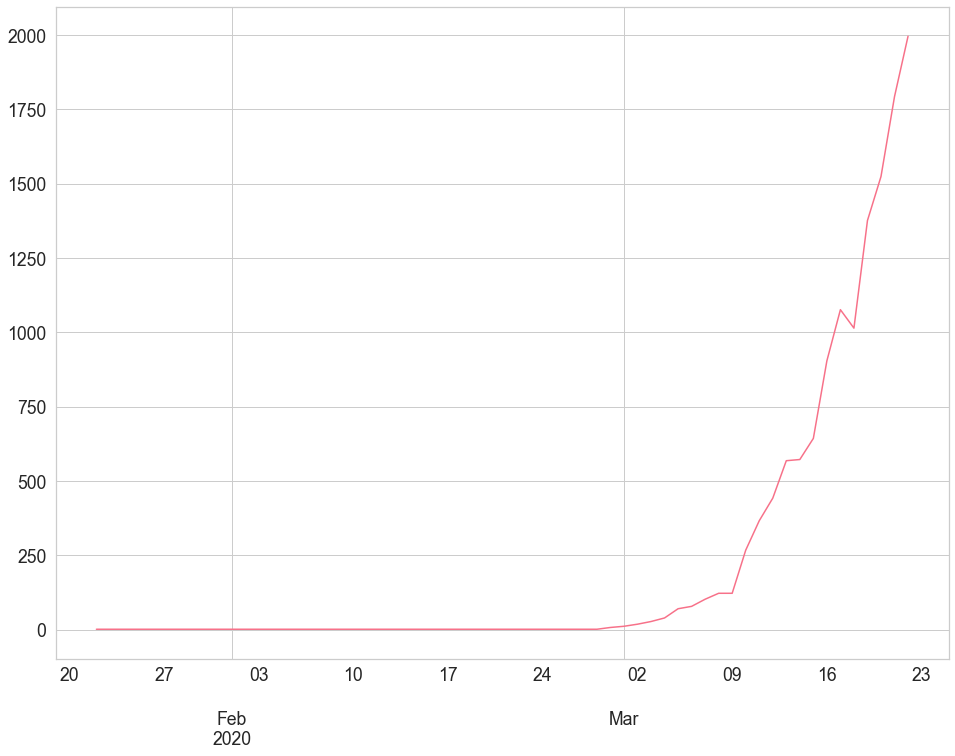

In [40]:
wa_data_loader = LSTM_data_loader(df=states_df,
                          region_abr='WA',
                          country='US',
                          state_mapper=state_mapper)

wa_data_loader.subset_df()
wa_data_loader.transform_df_datetime()
wa_data_loader.df.plot(label="Confirmed Cases")

In [41]:
wa_data_loader.gen_data_sets(test_data_size=7)

X_train, y_train = wa_data_loader.set_seq(train=True, sequence_lenth=3)
X_test, y_test = wa_data_loader.set_seq(train=False, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

model, _, _ = train_lstm(model,
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      epochs=300)

Epoch 0 train loss: 2.411163806915283 test loss: 17.456514358520508
Epoch 50 train loss: 0.6631855368614197 test loss: 3.1376967430114746
Epoch 100 train loss: 0.45877087116241455 test loss: 1.4010326862335205
Epoch 150 train loss: 0.44648244976997375 test loss: 1.3606666326522827
Epoch 200 train loss: 0.4474634528160095 test loss: 1.4032245874404907
Epoch 250 train loss: 0.453236848115921 test loss: 1.2750556468963623


In [42]:
# 
seq_length = model.sequences

outs = predict_future(n_future=len(X_test), 
                      time_data=X_test, 
                      sequece_lenth=model.sequences, 
                      model=model)

true_cases = wa_data_loader.scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
print(true_cases)

predicted_cases = wa_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[1376.     1524.     1792.9999]
[1597.89491653 1859.23181629 2140.10957146]


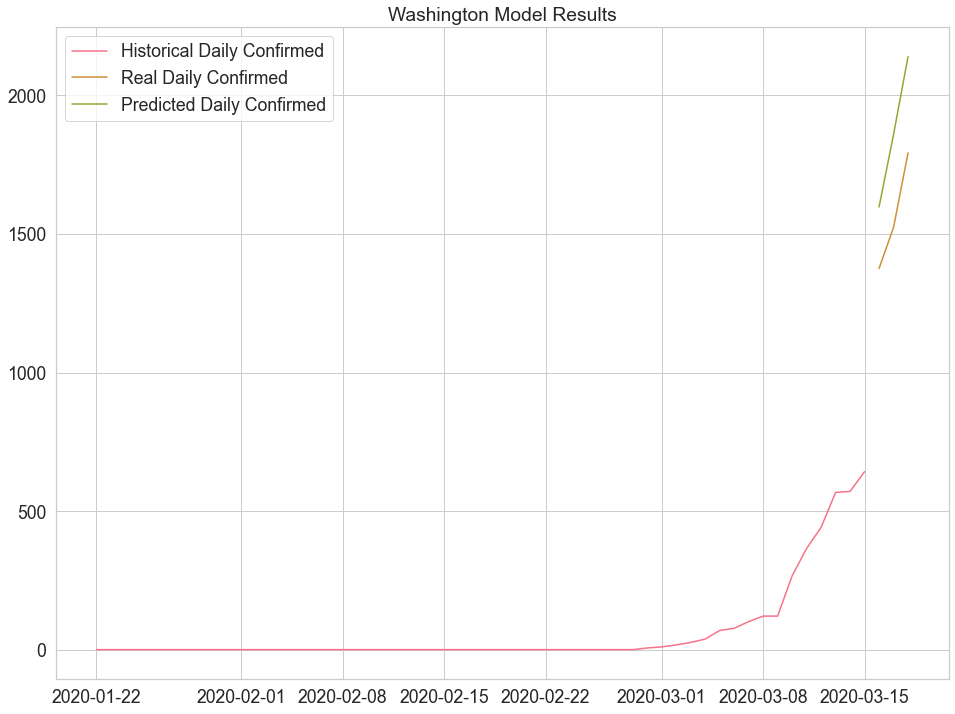

In [43]:
plt.plot(
  wa_data_loader.df.index[:len(wa_data_loader.train_data)],
  wa_data_loader.scaler.inverse_transform(wa_data_loader.train_data).flatten(),
  label='Historical Daily Confirmed'
)

plt.plot(
  wa_data_loader.df.index[len(wa_data_loader.train_data):len(wa_data_loader.train_data) + len(true_cases)],
  true_cases,
  label='Real Daily Confirmed'
)

plt.plot(
  wa_data_loader.df.index[len(wa_data_loader.train_data):len(wa_data_loader.train_data) + len(true_cases)],
  predicted_cases,
  label='Predicted Daily Confirmed'
)

plt.title(label='Washington Model Results')
plt.legend()

### CO

Lets try a state with some cases, but considerably less data, Colorado.

In [44]:
co_data_loader = LSTM_data_loader(df=states_df,
                          region_abr='CO',
                          country='US',
                          state_mapper=state_mapper)

In [45]:
co_data_loader.subset_df()
co_data_loader.df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20
0,0,0,0,0,0,0,0,0,0,0,...,49,101,131,160,160,184,277,363,390,476


In [46]:
co_data_loader.transform_df_datetime()
co_data_loader.df.head()

Data in cumulative


2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
dtype: int64

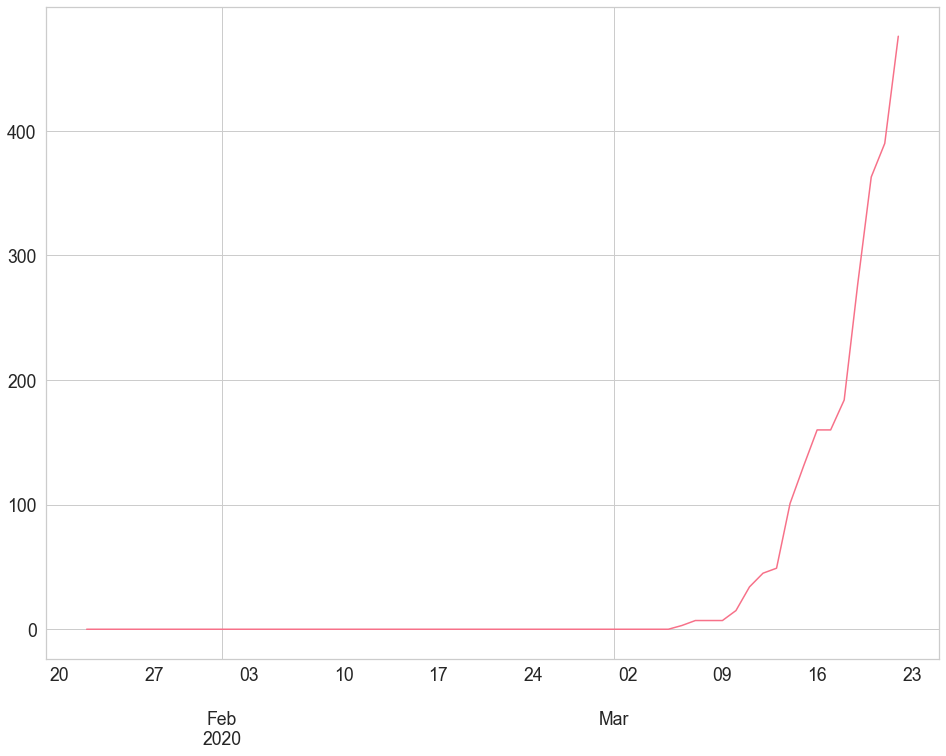

In [47]:
co_data_loader.df.plot(label="Confirmed Cases")

In [48]:
co_data_loader.gen_data_sets(test_data_size=0)

In [49]:
X_train, y_train = co_data_loader.set_seq(train=True, sequence_lenth=3)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

In [50]:
model = LSTM_Predictor(
    features=1,
    neurons=512,
    sequences=3,
    layers=2,
    dropout=0.3)

In [51]:
model, _, _ = train_lstm(model,
                      X_train,
                      y_train,
                      epochs=300)

Epoch 0 train loss: 2.207463264465332
Epoch 50 train loss: 0.5127536654472351
Epoch 100 train loss: 0.3723390996456146
Epoch 150 train loss: 0.3793192505836487
Epoch 200 train loss: 0.38776540756225586
Epoch 250 train loss: 0.3825158178806305


In [52]:
seq_length = model.sequences
days_to_predict = 10

outs = predict_future(n_future=days_to_predict, 
                      time_data=X_train, 
                      sequece_lenth=model.sequences, 
                      model=model)

predicted_cases = co_data_loader.scaler.inverse_transform(
  np.expand_dims(outs, axis=0)
).flatten()
print(predicted_cases)

[ 335.70079923  385.95181584  450.4088819   529.04898787  622.49228477
  731.49258327  856.44913149  996.89963913 1151.04255295 1315.43495369]


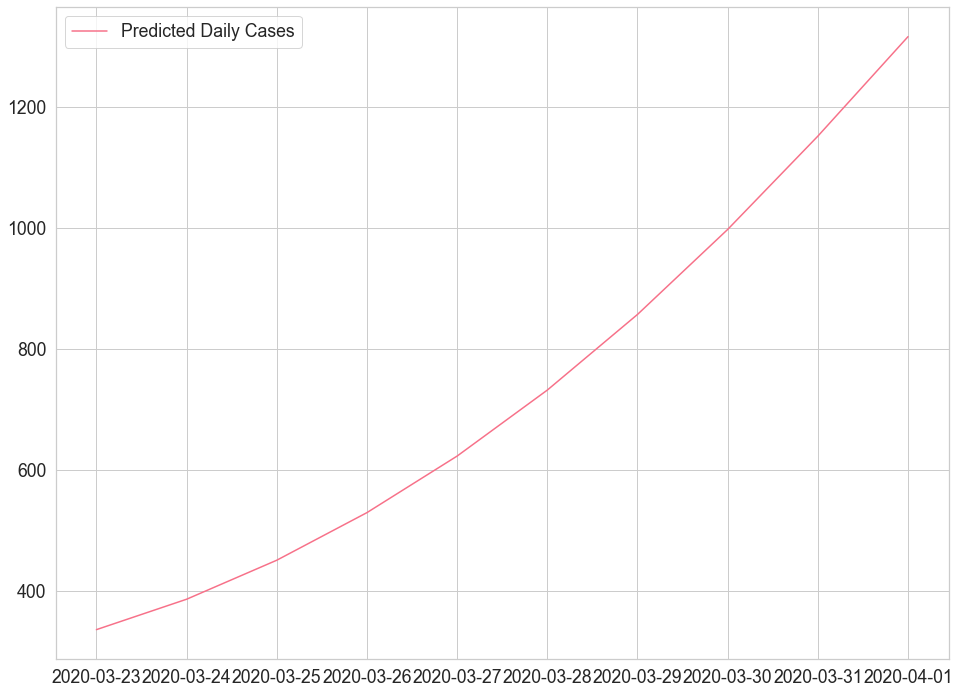

In [53]:
predicted_index = pd.date_range(
  start=co_data_loader.df.index[-1],
  periods=10 + 1,
  closed='right'
)

predicted_cases = pd.Series(
  data=predicted_cases,
  index=predicted_index
)

plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend()

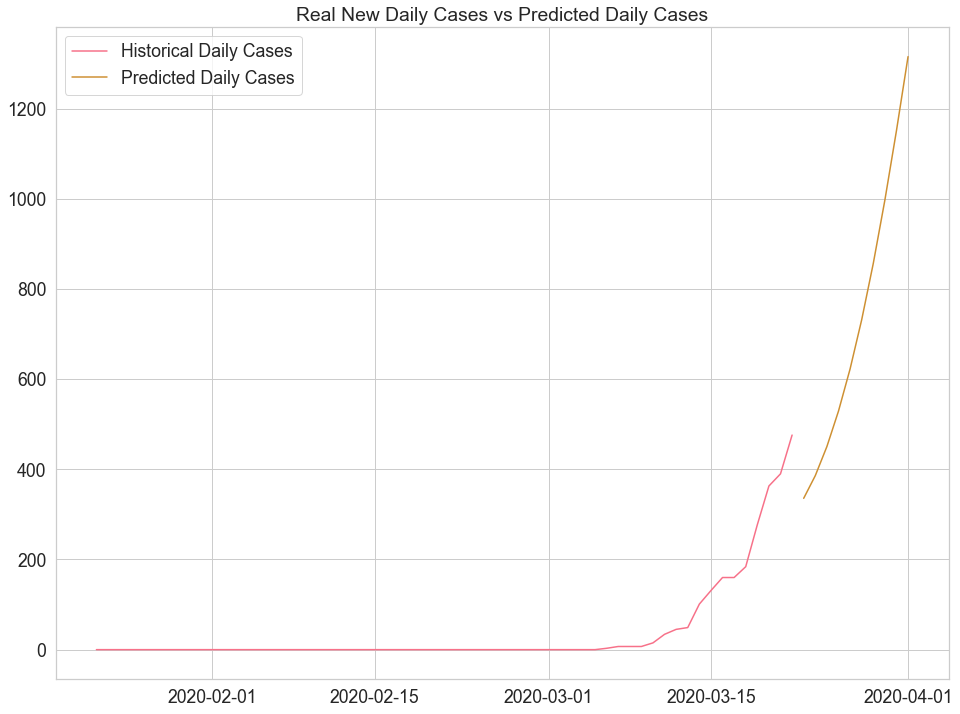

In [54]:
plt.plot(co_data_loader.df, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.title('Real New Daily Cases vs Predicted Daily Cases')
plt.legend()